In [1]:
# This code works in Python 3.10.6
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import dgl
import random
import torch
from torch import optim
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, Linear, SAGEConv
import torch_geometric.utils.convert
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

Create Metagraph

In [2]:
import import_ipynb
import pubmed_dataset

importing Jupyter notebook from pubmed_dataset.ipynb
HeteroData(
  disease={
    x=[454, 200],
    y=[454],
  },
  gene={ x=[13561, 200] },
  chemical={ x=[26522, 200] },
  species={ x=[2863, 200] },
  (gene, to, gene)={ edge_index=[2, 40] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 70] },
  (chemical, to, chemical)={ edge_index=[2, 108] },
  (chemical, to, species)={ edge_index=[2, 18] },
  (species, to, gene)={ edge_index=[2, 6] }
)


In [3]:
data = pubmed_dataset.data

In [4]:
dataset = data.clone()
# Node features are removed as a temporary fix to the errors in conversion of 
#Pytorch Geometric HeteroData to DGL graph. Node features are not important for creating metagraph.
dataset['disease'].x = dataset['disease'].x[:405, :]
dataset['disease'].y = dataset['disease'].y[:405]
dataset['gene'].x = dataset['gene'].x[:13499, :]
dataset['chemical'].x = dataset['chemical'].x[:26406, :]
dataset['species'].x = dataset['species'].x[:2741, :]

In [5]:
#Create metagraph
g = torch_geometric.utils.convert.to_dgl(dataset)
meta_g= g.metagraph()

Train PubMed

In [6]:
transform = T.RandomNodeSplit(split='train_rest', num_val=0.15, num_test=0.15)
data = transform(data)
data

HeteroData(
  disease={
    x=[454, 200],
    y=[454],
    train_mask=[454],
    val_mask=[454],
    test_mask=[454],
  },
  gene={ x=[13561, 200] },
  chemical={ x=[26522, 200] },
  species={ x=[2863, 200] },
  (gene, to, gene)={ edge_index=[2, 40] },
  (gene, to, disease)={ edge_index=[2, 1] },
  (chemical, to, gene)={ edge_index=[2, 70] },
  (chemical, to, chemical)={ edge_index=[2, 108] },
  (chemical, to, species)={ edge_index=[2, 18] },
  (species, to, gene)={ edge_index=[2, 6] }
)

In [7]:
class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, hidden_channels, out_channels, num_layers):
        super().__init__()

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HeteroConv({
                edge_type: SAGEConv((-1, -1), hidden_channels)
                for edge_type in metadata[1]
            })
            self.convs.append(conv)

        self.lin = Linear(hidden_channels, out_channels)

    def forward(self, x_dict, edge_index_dict):
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {key: F.leaky_relu(x) for key, x in x_dict.items()}
        return self.lin(x_dict['disease'])


model = HeteroGNN(data.metadata(), hidden_channels=256, out_channels=8,
                  num_layers=4)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
data, model = data.to(device), model.to(device)

with torch.no_grad():  # Initialize lazy modules.
    out = model(data.x_dict, data.edge_index_dict)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x_dict, data.edge_index_dict)
    mask = data['disease'].train_mask
    loss = F.cross_entropy(out[mask], data['disease'].y[mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred = model(data.x_dict, data.edge_index_dict).argmax(dim=-1)

    accs = []
    for split in ['train_mask', 'val_mask', 'test_mask']:
        mask = data['disease'][split]
        acc = (pred[mask] == data['disease'].y[mask]).sum() / mask.sum()
        accs.append(float(acc))
    return accs


for epoch in range(1, 101):
    loss = train()
    train_acc, val_acc, test_acc = test()
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {test_acc:.4f}')

Epoch: 010, Loss: 0.9786, Train: 0.6887, Val: 0.4853, Test: 0.5441
Epoch: 020, Loss: 0.1600, Train: 0.9591, Val: 0.4412, Test: 0.5441
Epoch: 030, Loss: 0.0146, Train: 0.9969, Val: 0.4412, Test: 0.5441
Epoch: 040, Loss: 0.0528, Train: 0.9937, Val: 0.5000, Test: 0.5588
Epoch: 050, Loss: 0.3886, Train: 0.9811, Val: 0.4559, Test: 0.4706
Epoch: 060, Loss: 0.0412, Train: 1.0000, Val: 0.4118, Test: 0.5000
Epoch: 070, Loss: 0.0095, Train: 1.0000, Val: 0.5000, Test: 0.5147
Epoch: 080, Loss: 0.0028, Train: 1.0000, Val: 0.4412, Test: 0.5441
Epoch: 090, Loss: 0.0026, Train: 1.0000, Val: 0.4706, Test: 0.5147
Epoch: 100, Loss: 0.0030, Train: 1.0000, Val: 0.5000, Test: 0.5294


Graph (without node features) generated from HGEN

In [8]:
G = nx.read_gexf("PubMed_hgen.gexf")

Adding node features to graph

importing Jupyter notebook from pubmed_gmm_features.ipynb
no of class disease0 node samples - 80
no of class disease1 node samples - 80
no of class disease2 node samples - 80
no of class disease3 node samples - 80
no of class disease4 node samples - 80
no of class disease5 node samples - 81
no of class disease6 node samples - 81
no of class disease7 node samples - 81
no of class gene node samples - 313
no of class chemical node samples - 564
no of class species node samples - 45


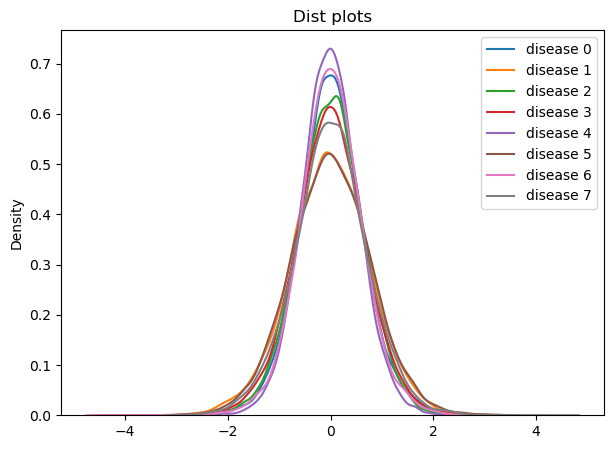

In [9]:
#Load node features 
import pubmed_gmm_features

In [10]:
disease_node_features = pubmed_gmm_features.disease_node_features
gene_node_features = pubmed_gmm_features.gene_node_features
chemical_node_features = pubmed_gmm_features.chemical_node_features
species_node_features = pubmed_gmm_features.species_node_features

In [11]:
 #Adding node degree
for node in G.nodes():
    d = G.degree(node)
    G.nodes[node]["degree"] = d

In [12]:
#Generate graphs of 2-hop neighbourhood
def graph_gen(nodeid):
    
    num_hops = 2  
    nodes = []
    edges = []
    #Get small graph nodes
    nodes = nx.single_source_shortest_path_length(G, nodeid, cutoff=num_hops).keys() 
    if 3 <= len(nodes) <= 80:
        graph = nx.ego_graph(G,nodeid, num_hops, center=True,undirected = True)
        #Get small graph edges
        edges = [e for e in graph.edges]
        #nx.draw(graph, with_labels = True)
        #plt.show()
        #print('nodeid',nodeid)
        #print('node count',len(nodes))
        #print('edge count',len(edges))
        return nodes, edges
    else:
        return None, None

In [13]:
def remap_indices(node_list):
    val_list = [*range(0, len(node_list), 1)]
    return dict(zip(node_list,val_list))  

In [14]:
def preprocess_edges(edgelist,node_list):
    res = [[node_list[i] for i, j in edgelist],[node_list[j] for i, j in edgelist]] 
    node_from = torch.tensor(res[0])
    node_to = torch.tensor(res[1])
    edges = torch.concat((node_from,node_to)).reshape(-1,len(node_from))
    return edges

In [15]:
def get_node_type(node_id):
    if (int(node_id) in list(disease_node_features['nodeId'])):
        return 'disease'
    elif (int(node_id) in list(gene_node_features['nodeId'])):
        return 'gene'
    elif (int(node_id) in list(chemical_node_features['nodeId'])):
        return 'chemical'
    elif (int(node_id) in list(species_node_features['nodeId'])):
        return 'species'

In [16]:
all_edges = {}

In [17]:
#List of edges in metagraph of PubMed
list(meta_g.edges())

[('chemical', 'chemical'),
 ('chemical', 'gene'),
 ('chemical', 'species'),
 ('gene', 'disease'),
 ('gene', 'gene'),
 ('species', 'gene')]

In [18]:
def create_dataset(nodes,edges,disease_node_features,gene_node_features,chemical_node_features,
                   species_node_features,node_id):
    
    disease_df = disease_node_features[disease_node_features["nodeId"].isin([int(x) for x in nodes])]
    gene_df = gene_node_features[gene_node_features["nodeId"].isin([int(x) for x in nodes])]
    chemical_df = chemical_node_features[chemical_node_features["nodeId"].isin([int(x) for x in nodes])]
    species_df = species_node_features[species_node_features["nodeId"].isin([int(x) for x in nodes])] 
    
    #Nodes   
    disease = np.asarray(disease_df.drop(columns=['nodeId','class']))
    gene = np.asarray(gene_df.drop(columns=['nodeId']))
    chemical = np.asarray(chemical_df.drop(columns=['nodeId']))
    species = np.asarray(species_df.drop(columns=['nodeId']))
    
    x_disease = torch.tensor(disease).to(dtype=torch.float32)
    y_disease = torch.tensor(np.array(disease_df["class"]), dtype=torch.long)
    x_gene = torch.tensor(gene).to(dtype=torch.float32)
    x_chemical = torch.tensor(chemical).to(dtype=torch.float32)
    x_species = torch.tensor(species).to(dtype=torch.float32)
    
    #Edges
    source,dest =list(map(list, zip(*edges)))
    chemical_to_chemical = []
    chemical_to_gene = []
    chemical_to_species = []
    gene_to_disease = []
    gene_to_gene = []
    species_to_gene = []
    
    remaining_edges = []
    for i in range(len(edges)):

        if (int(source[i]) in list(chemical_df['nodeId'])) and (int(dest[i]) in list(chemical_df['nodeId'])):
                chemical_to_chemical.append((int(source[i]),int(dest[i])))
            
        elif (int(source[i]) in list(chemical_df['nodeId'])) and (int(dest[i]) in list(gene_df['nodeId'])):
                chemical_to_gene.append((int(source[i]),int(dest[i])))
            
        elif (int(source[i]) in list(chemical_df['nodeId'])) and (int(dest[i]) in list(species_df['nodeId'])):
                chemical_to_species.append((int(source[i]),int(dest[i])))
            
        elif (int(source[i]) in list(gene_df['nodeId'])) and (int(dest[i]) in list(disease_df['nodeId'])):
                gene_to_disease.append((int(source[i]),int(dest[i])))
            
        elif (int(source[i]) in list(gene_df['nodeId'])) and (int(dest[i]) in list(gene_df['nodeId'])):
                gene_to_gene.append((int(source[i]),int(dest[i])))
            
        elif (int(source[i]) in list(species_df['nodeId'])) and (int(dest[i]) in list(gene_df['nodeId'])):
                species_to_gene.append((int(source[i]),int(dest[i])))
      
        else:
            #The edges not present in the metagraph  
            source_node_type = get_node_type(source[i])
            dest_node_type = get_node_type(dest[i])
            remaining_edges.append((source_node_type,dest_node_type))
            #remaining_edges.append((int(source[i]),int(dest[i])))
    

    all_edges[node_id] = [*chemical_to_chemical,*chemical_to_gene,*chemical_to_species,
                          *gene_to_disease,*gene_to_gene,*species_to_gene]
               
    #Re-map indices to correct range
    disease_nodes_mapping = remap_indices(list(disease_df["nodeId"]))
    gene_nodes_mapping = remap_indices(list(gene_df["nodeId"]))
    chemical_nodes_mapping = remap_indices(list(chemical_df["nodeId"]))
    species_nodes_mapping = remap_indices(list(species_df["nodeId"]))
    
    node_list = {}
    for d in [disease_nodes_mapping, gene_nodes_mapping, chemical_nodes_mapping,species_nodes_mapping]:
        node_list.update(d)
    
    #Create Hetero Data      
    small_graph = HeteroData({'disease':{'x': x_disease, 'y':y_disease}, 'gene':{'x': x_gene},
                              'chemical':{'x': x_chemical}, 'species':{'x': x_species}})

        
    if chemical_to_chemical:
        edge_index_chemical_chemical = preprocess_edges(chemical_to_chemical,node_list)
        small_graph['chemical','to','chemical'].edge_index = edge_index_chemical_chemical
    if chemical_to_gene:
        edge_index_chemical_gene = preprocess_edges(chemical_to_gene,node_list)
        small_graph['chemical','to','gene'].edge_index = edge_index_chemical_gene
    if chemical_to_species:
        edge_index_chemical_species = preprocess_edges(chemical_to_species,node_list)
        small_graph['chemical','to','species'].edge_index = edge_index_chemical_species
    if gene_to_disease:
        edge_index_gene_disease = preprocess_edges(gene_to_disease,node_list)
        small_graph['gene','to','disease'].edge_index = edge_index_gene_disease
    if gene_to_gene:
        edge_index_gene_gene = preprocess_edges(gene_to_gene,node_list)
        small_graph['gene','to','gene'].edge_index = edge_index_gene_gene
    if species_to_gene:
        edge_index_species_gene = preprocess_edges(species_to_gene,node_list)
        small_graph['species','to','gene'].edge_index = edge_index_species_gene

    #Removing isolated nodes
    transform = T.Compose([T.remove_isolated_nodes.RemoveIsolatedNodes()])
    small_graph = transform(small_graph)
    
    #Adding test mask for prediction
    transform = T.RandomNodeSplit(split='train_rest', num_val=0.0, num_test=1.0)
    small_graph = transform(small_graph)
    
    return small_graph, remaining_edges

In [19]:
def evaluate_gnn(small_graph):
    
    with torch.no_grad():
        model.eval()
        #The pred is not used for accuracy, the softmax is used
        pred = model(small_graph.x_dict, small_graph.edge_index_dict).argmax(dim=-1)
        
        #Getting class prediction probabilities from the softmax layer
        softmax = model(small_graph.x_dict, small_graph.edge_index_dict).softmax(dim=-1)
        
        mask = small_graph['disease'].test_mask
        correct = (pred[mask] == small_graph['disease'].y[mask])
               
        print(small_graph)
        print('Prediction:',pred[mask])
        print('Ground Truth:',small_graph['disease'].y[mask])
        print(correct)
        print(softmax)
        
        correct_indices = [i for i, x in enumerate(correct.tolist()) if x]
        print('correct indices',correct_indices)
        
        #Taking softmax values of the nodes for which prediction is correct
        softmax_pred_list = [softmax.tolist()[i] for i in correct_indices]
        #print(softmax_pred_list)
        print('------------------------------------------------------------------')
        
        return softmax_pred_list, correct_indices

In [20]:
n_list = dict((n,d['degree']) for n,d in G.nodes().items() if d['degree']>=2)
print('No of 2-hop graphs:',len(n_list))
#n_list= random.sample(node_subset.keys(), 1200)

No of 2-hop graphs: 1255


In [21]:
softmax_dict = {}
nodefeature_dict = {}
original_edge_count = []
removed_edge_count = []
removed_edges_list = []
for nodeid in n_list: 
    #Generate small Graphs
    nodes, edges = graph_gen(nodeid)
    if not (nodes is None):

        
            small_graph_data, removed_edges = create_dataset(nodes,edges,
                                  disease_node_features,gene_node_features,
                                  chemical_node_features,species_node_features,nodeid)
            

            edge_list = all_edges[nodeid]
            graph = nx.Graph(edge_list)
            if not nx.is_empty(graph) and nx.is_connected(graph):

                if (small_graph_data['disease'].x.nelement()!=0) and \
                (small_graph_data['chemical','to','chemical']) and \
                (small_graph_data['chemical','to','gene']) and \
                (small_graph_data['chemical','to','species']) and \
                (small_graph_data['gene','to','disease']) and \
                (small_graph_data['gene','to','gene']):


                    print('nodeid',nodeid)
                    print('node count',small_graph_data.num_nodes)
                    print('edge count',small_graph_data.num_edges)

                    original_edge_count.append(len(edges))
                    removed_edge_count.append(len(removed_edges))
                    removed_edges_list.append(set(removed_edges))
                    print('Original edge_count',len(edges))
                    print('Removed edge_count',len(removed_edges))
                    print('Removed edges',removed_edges)

                    #graph = nx.ego_graph(G,nodeid, 2, center=True,undirected = True)
                    #nx.draw(graph, with_labels = True)
                    #plt.show() 

                    #Evaluate trained PubMed on smaller graphs

                    softmax,correct_indices  = evaluate_gnn(small_graph_data)
                    softmax_dict[nodeid] = softmax
                    nodefeature_dict[nodeid]={'gene':small_graph_data['gene'].x,
                                         'disease':small_graph_data['disease'].x[correct_indices],
                                         'chemical':small_graph_data['chemical'].x,
                                          'species':small_graph_data['species'].x}
                    #print(small_graph_data)

                else:
                    #print("The next graph could not be evaluated. Required edges are missing.")
                    pass

            else:
                #print("The next graph could not be loaded. Node count is less than 3")
                pass


nodeid 85
node count 27
edge count 27
Original edge_count 42
Removed edge_count 15
Removed edges [('chemical', 'disease'), ('chemical', 'disease'), ('chemical', 'disease'), ('disease', 'gene'), ('disease', 'gene'), ('disease', 'disease'), ('disease', 'gene'), ('gene', 'chemical'), ('gene', 'chemical'), ('gene', 'chemical'), ('disease', 'chemical'), ('chemical', 'disease'), ('disease', 'gene'), ('gene', 'chemical'), ('gene', 'chemical')]
HeteroData(
  disease={
    x=[2, 200],
    y=[2],
    train_mask=[2],
    val_mask=[2],
    test_mask=[2],
  },
  gene={ x=[10, 200] },
  chemical={ x=[14, 200] },
  species={ x=[1, 200] },
  (chemical, to, chemical)={ edge_index=[2, 12] },
  (chemical, to, gene)={ edge_index=[2, 6] },
  (chemical, to, species)={ edge_index=[2, 1] },
  (gene, to, disease)={ edge_index=[2, 2] },
  (gene, to, gene)={ edge_index=[2, 6] }
)
Prediction: tensor([3, 6])
Ground Truth: tensor([3, 6])
tensor([True, True])
tensor([[2.4675e-14, 3.2209e-08, 6.7314e-12, 9.9911e-01, 

In [22]:
print("No. of graphs evaluated: ",len(softmax_dict))

No. of graphs evaluated:  14


In [23]:
print('Average number of original edges',round(np.mean(original_edge_count)))

Average number of original edges 67


In [24]:
print('Average number of edges removed',round(np.mean(removed_edge_count)))

Average number of edges removed 32


In [25]:
#The edges that are removed across all graphs
print('Edges removed', set.union(*removed_edges_list))

Edges removed {('species', 'chemical'), ('chemical', 'disease'), ('disease', 'disease'), ('gene', 'chemical'), ('disease', 'chemical'), ('gene', 'species'), ('disease', 'gene'), ('species', 'disease'), ('disease', 'species')}


In [26]:
#Getting the list of predictions for each class
prob_class0_dict = {}
prob_class1_dict = {}
prob_class2_dict = {}
prob_class3_dict = {}
prob_class4_dict = {}
prob_class5_dict = {}
prob_class6_dict = {}
prob_class7_dict = {}
for nodeid in softmax_dict:
    

    if len(softmax_dict[nodeid]) > 0:
        list0= []
        list1= []
        list2= []
        list3= []
        list4= []
        list5= []
        list6= []
        list7= []

        for prob in softmax_dict[nodeid]:        
            list0.append(prob[0])        
            list1.append(prob[1]) 
            list2.append(prob[2]) 
            list3.append(prob[3])
            list4.append(prob[4])
            list5.append(prob[5])
            list6.append(prob[6])
            list7.append(prob[7])

     #Taking max probability of all nodes of each class in a graph
    if len(list0) != 0:
        prob_class0_dict[nodeid]=max(list0)
    if len(list1) != 0:
        prob_class1_dict[nodeid]=max(list1)
    if len(list2) != 0:
        prob_class2_dict[nodeid]=max(list2)
    if len(list3) != 0:
        prob_class3_dict[nodeid]=max(list3)
    if len(list4) != 0:
        prob_class4_dict[nodeid]=max(list4)
    if len(list5) != 0:
        prob_class5_dict[nodeid]=max(list5)
    if len(list6) != 0:
        prob_class6_dict[nodeid]=max(list6)
    if len(list7) != 0:
        prob_class7_dict[nodeid]=max(list7)

Getting the highest prediction probability for each class of author node

In [27]:
max_pred0 = max(prob_class0_dict.values())
max_pred1 = max(prob_class1_dict.values())
max_pred2 = max(prob_class2_dict.values())
max_pred3 = max(prob_class3_dict.values())
max_pred4 = max(prob_class4_dict.values())
max_pred5 = max(prob_class5_dict.values())
max_pred6 = max(prob_class6_dict.values())
max_pred7 = max(prob_class7_dict.values())

In [28]:
# Getting nodeid to re-generate 2 hop graph which maximizes prediction
class0_nodeid = max(prob_class0_dict, key=prob_class0_dict.get)
class1_nodeid = max(prob_class1_dict, key=prob_class1_dict.get)
class2_nodeid = max(prob_class2_dict, key=prob_class2_dict.get)
class3_nodeid = max(prob_class3_dict, key=prob_class3_dict.get)
class4_nodeid = max(prob_class4_dict, key=prob_class4_dict.get)
class5_nodeid = max(prob_class5_dict, key=prob_class5_dict.get)
class6_nodeid = max(prob_class6_dict, key=prob_class6_dict.get)
class7_nodeid = max(prob_class7_dict, key=prob_class7_dict.get)

In [29]:
print(class0_nodeid)
print(class1_nodeid)
print(class2_nodeid)
print(class3_nodeid)
print(class4_nodeid)
print(class5_nodeid)
print(class6_nodeid)
print(class7_nodeid)

489
655
489
1289
832
998
808
289


In [30]:
def plot_graph(nodeid, max_pred,nodetype,edges):

    classes = []
    graph = nx.Graph(edges)
    for g in graph.nodes():
        if g in list(gene_node_features['nodeId']):
            classes.append(0)
        elif g in list(disease_node_features['nodeId']):
            classes.append(1)
        elif g in list(chemical_node_features['nodeId']):
            classes.append(2)
        elif g in list(species_node_features['nodeId']):
            classes.append(3)
   
    
    color_class_map = {0: 'blue', 1: 'red', 2: 'darkgreen', 3: 'orange'}
    
    nx.set_node_attributes(graph, dict(zip(graph.nodes(), classes)), 'class')
    
    print('Number of nodes: ',graph.number_of_nodes())
    print('nodeid for generating 2 hop graph: ',nodeid)
    print(f'Max pred probability for class {nodetype} is {max_pred}')

    nx.draw(graph, 
    with_labels=False, node_color=[color_class_map[node[1]['class']] 
                        for node in graph.nodes(data=True)], 
            node_size=100,
        font_color='black')
    plt.show()

Plotting explanation graph with node features for each class of Disease node

Node colors:

Gene - Blue

Disease - Red

Chemical - Darkgreen

Species - Orange

In [31]:
def index_2d(prob_list, v):
    for i, x in enumerate(prob_list):
        if v in x:
            return (i, x.index(v))

In [32]:
def plot_node_feat(imp_feat):
    fig, ax = plt.subplots(figsize=(9.5,5))
    sns.distplot(imp_feat,color= 'orange',hist= False)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Feature values',fontsize=20)
    plt.ylabel('Density',fontsize=20)

    plt.show() 

Number of nodes:  23
nodeid for generating 2 hop graph:  489
Max pred probability for class 0 is 1.0


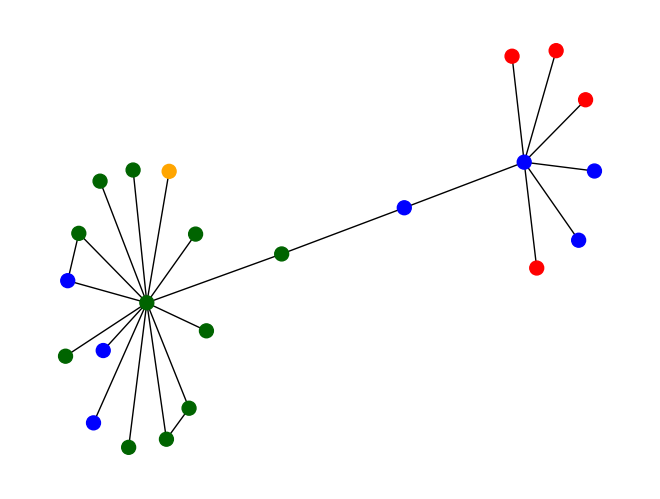

In [33]:
explanation_graph0 = plot_graph(class0_nodeid, max_pred0, 0, all_edges[class0_nodeid])

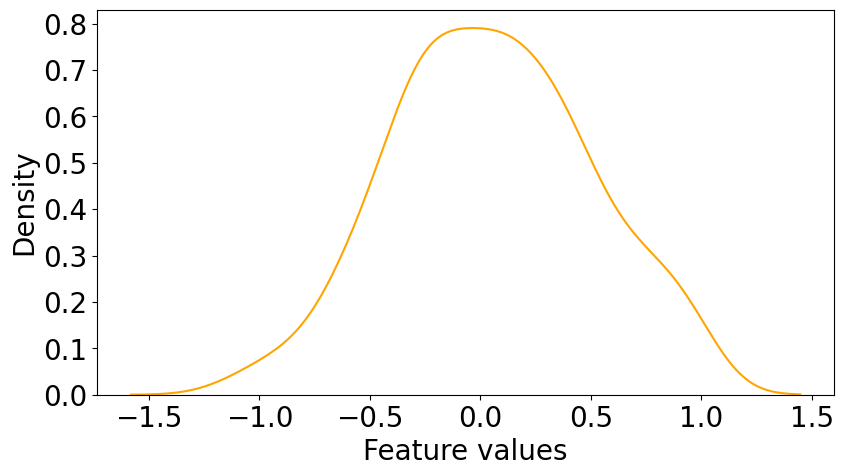

In [34]:
ind = index_2d(softmax_dict[class0_nodeid], max_pred0)[0]
disease0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease0_df)

Number of nodes:  33
nodeid for generating 2 hop graph:  655
Max pred probability for class 1 is 0.9944086670875549


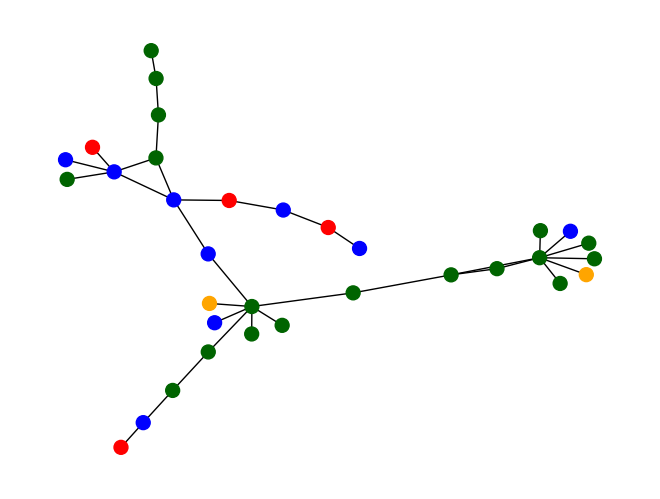

In [90]:
explanation_graph1 = plot_graph(class1_nodeid, max_pred1, 1, all_edges[class1_nodeid])

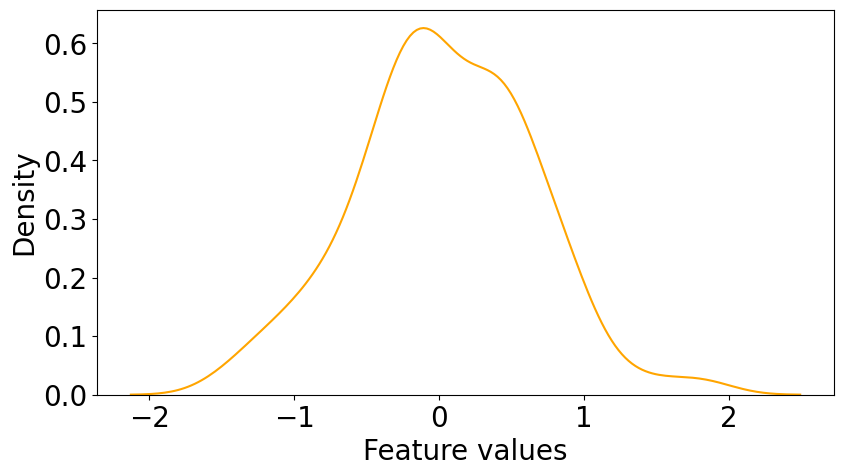

In [36]:
ind = index_2d(softmax_dict[class1_nodeid], max_pred1)[0]
disease1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease1_df)

Number of nodes:  23
nodeid for generating 2 hop graph:  489
Max pred probability for class 2 is 1.0


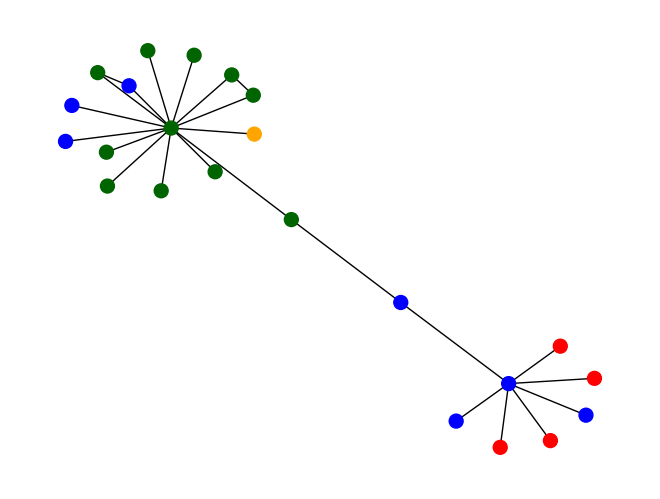

In [37]:
explanation_graph2 = plot_graph(class2_nodeid, max_pred2, 2, all_edges[class2_nodeid])

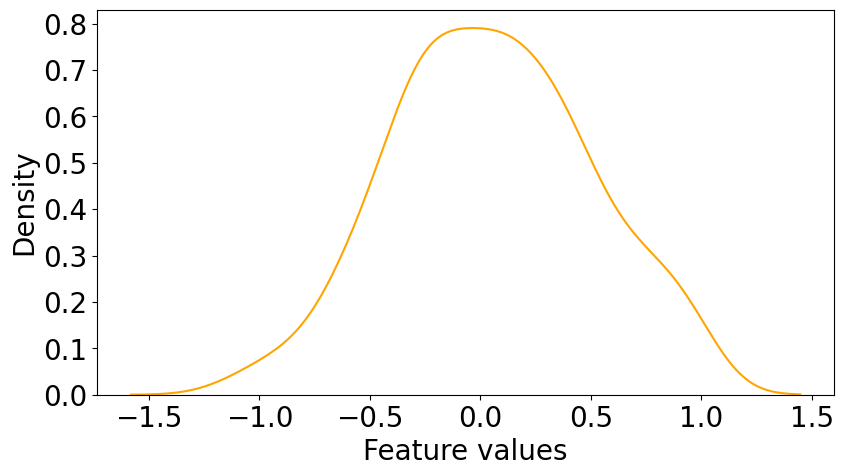

In [38]:
ind = index_2d(softmax_dict[class2_nodeid], max_pred2)[0]
disease2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease2_df)

Number of nodes:  23
nodeid for generating 2 hop graph:  1289
Max pred probability for class 3 is 1.0


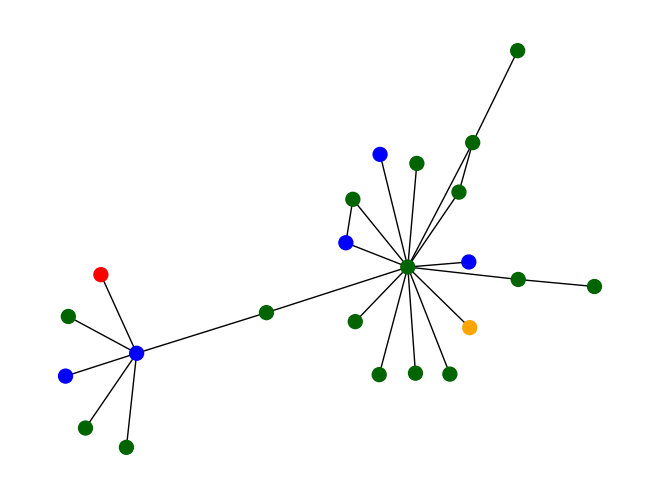

In [39]:
explanation_graph3 = plot_graph(class3_nodeid, max_pred3, 3, all_edges[class3_nodeid])

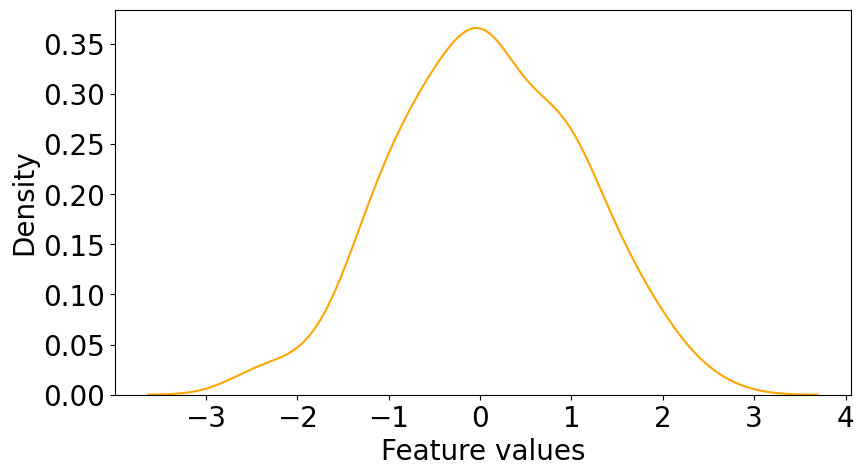

In [40]:
ind = index_2d(softmax_dict[class3_nodeid], max_pred3)[0]
disease3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease3_df)

Number of nodes:  39
nodeid for generating 2 hop graph:  832
Max pred probability for class 4 is 0.9998440742492676


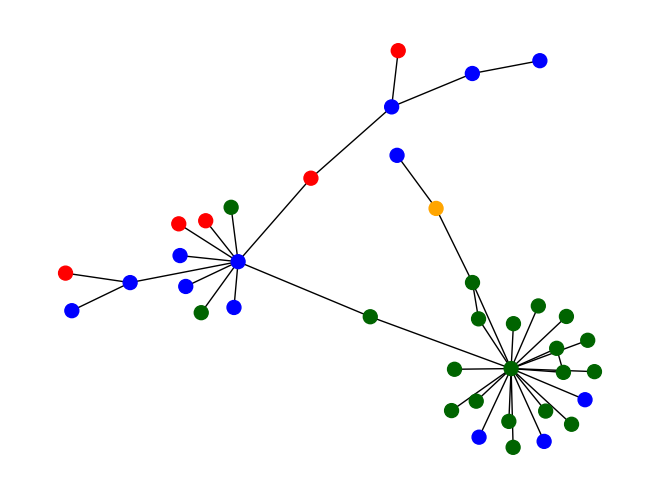

In [54]:
explanation_graph4 = plot_graph(class4_nodeid, max_pred4, 4, all_edges[class4_nodeid])

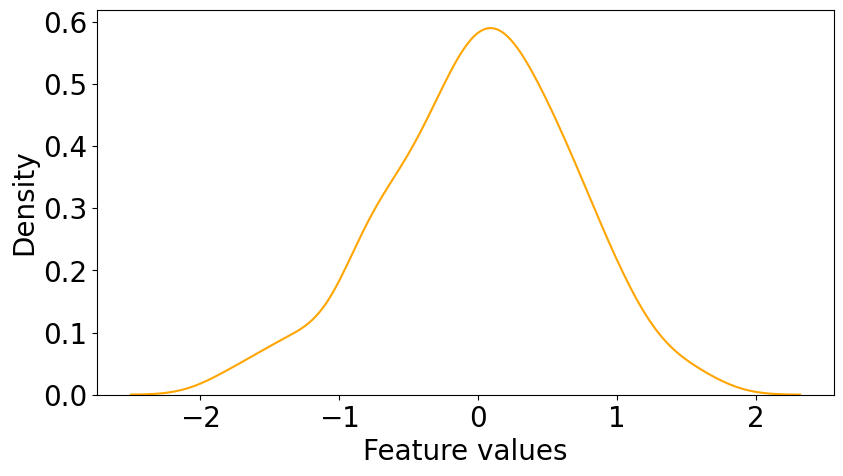

In [42]:
ind = index_2d(softmax_dict[class4_nodeid], max_pred4)[0]
disease4_df = pd.DataFrame(nodefeature_dict[class4_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease4_df)

Number of nodes:  41
nodeid for generating 2 hop graph:  998
Max pred probability for class 5 is 1.0


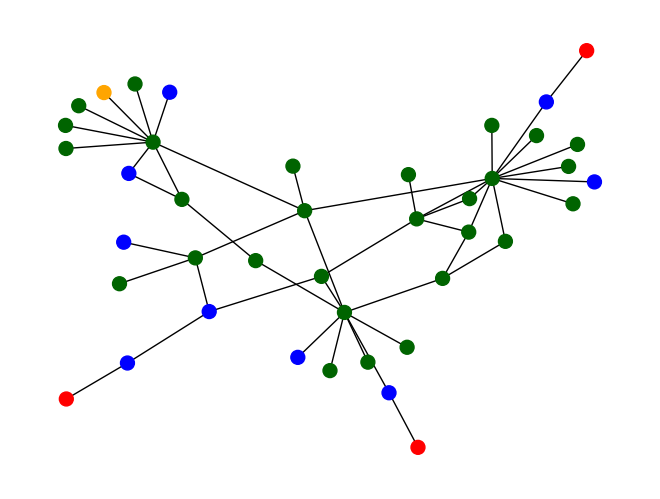

In [91]:
explanation_graph5 = plot_graph(class5_nodeid, max_pred5, 5, all_edges[class5_nodeid])

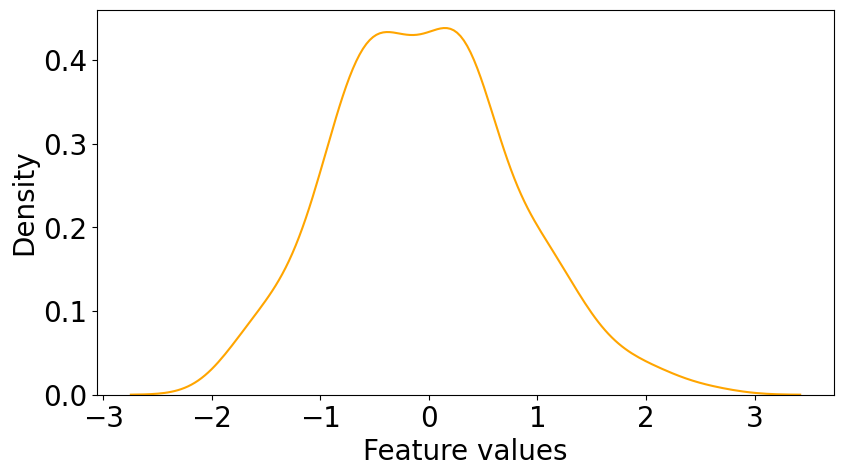

In [44]:
ind = index_2d(softmax_dict[class5_nodeid], max_pred5)[0]
disease5_df = pd.DataFrame(nodefeature_dict[class5_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease5_df)

Number of nodes:  27
nodeid for generating 2 hop graph:  808
Max pred probability for class 6 is 1.0


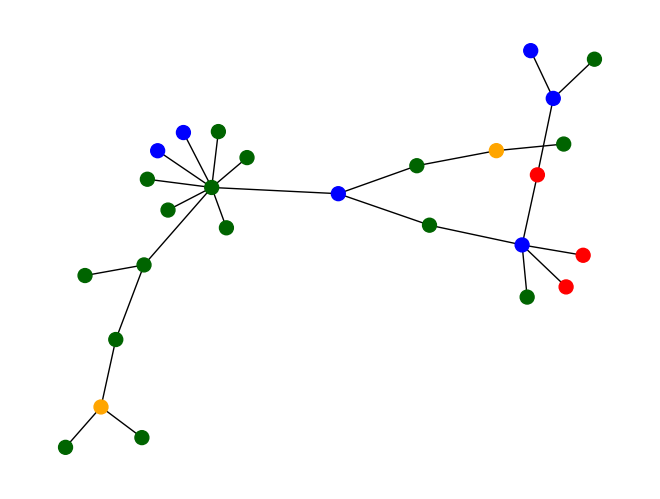

In [56]:
explanation_graph6 = plot_graph(class6_nodeid, max_pred6, 6, all_edges[class6_nodeid])

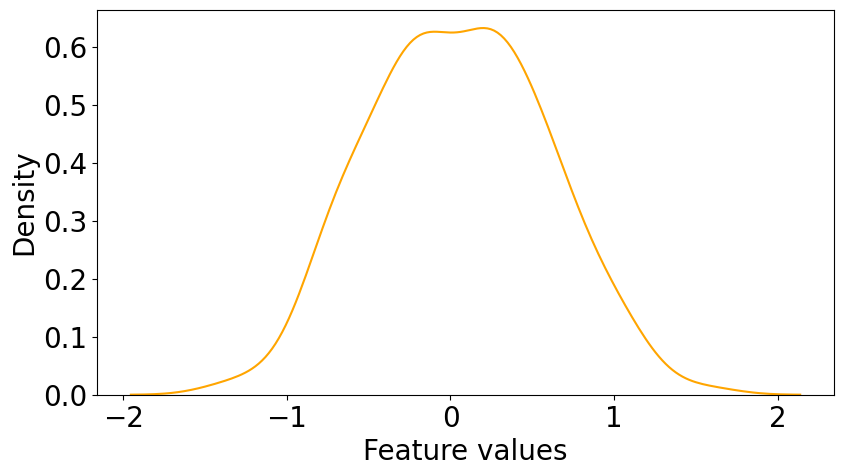

In [46]:
ind = index_2d(softmax_dict[class6_nodeid], max_pred6)[0]
disease6_df = pd.DataFrame(nodefeature_dict[class6_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease6_df)

Number of nodes:  44
nodeid for generating 2 hop graph:  289
Max pred probability for class 7 is 1.0


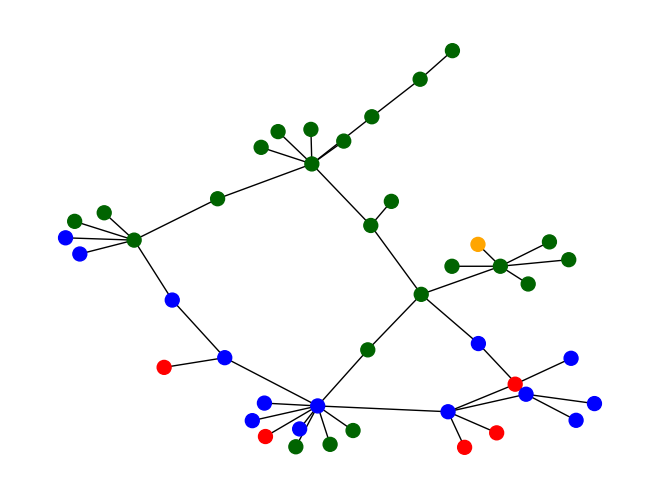

In [47]:
explanation_graph7 = plot_graph(class7_nodeid, max_pred7, 7, all_edges[class7_nodeid])

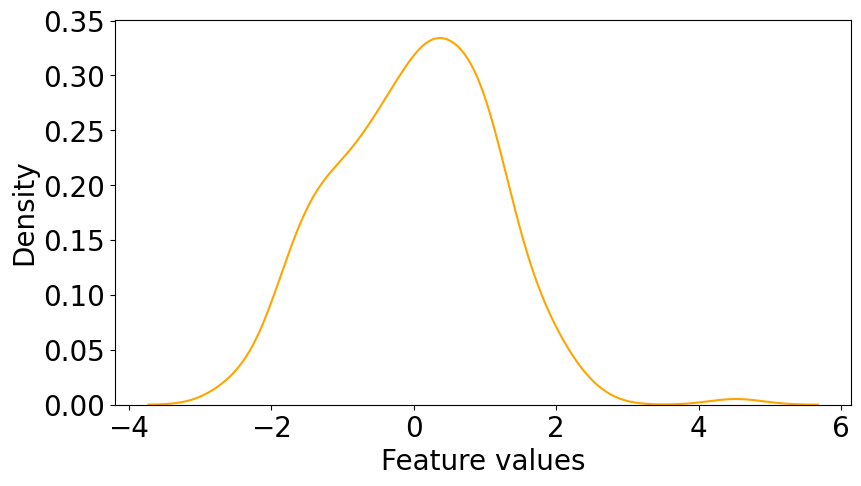

In [58]:
ind = index_2d(softmax_dict[class7_nodeid], max_pred7)[0]
disease7_df = pd.DataFrame(nodefeature_dict[class7_nodeid]['disease'].numpy()[ind])
plot_node_feat(disease7_df)

In [59]:
#Node features

In [60]:
#Gene

In [61]:
gene0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['gene'].numpy())

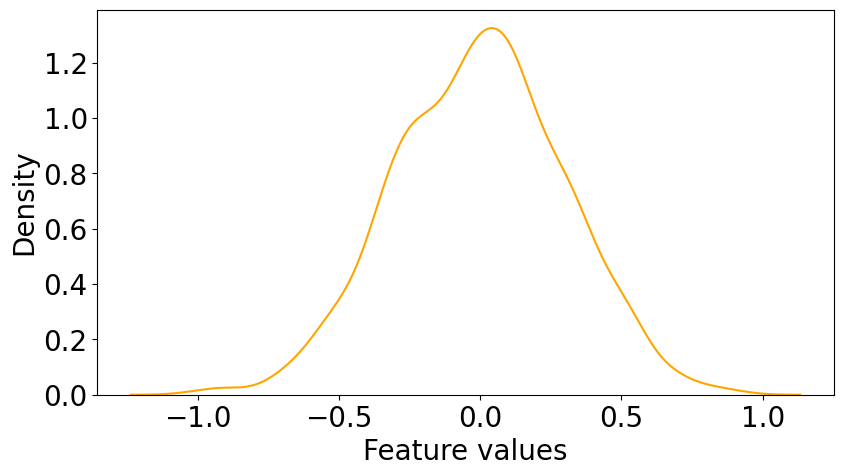

In [62]:
plot_node_feat(gene0_df)

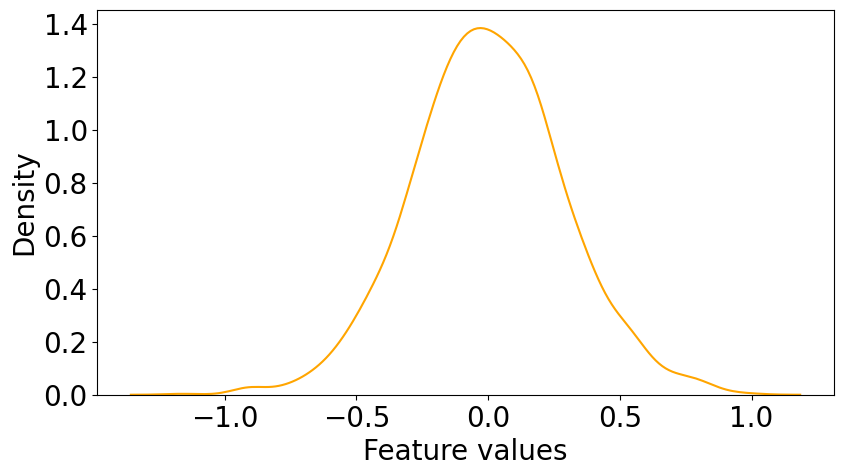

In [63]:
gene1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['gene'].numpy())
plot_node_feat(gene1_df)

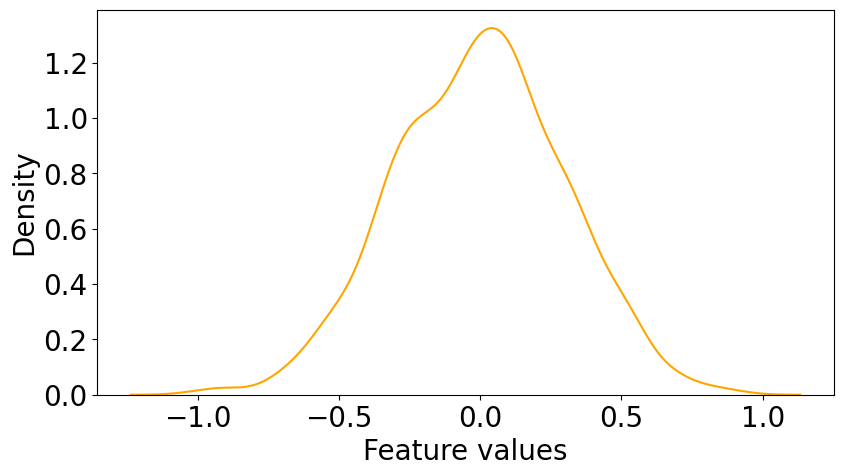

In [64]:
gene2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['gene'].numpy())
plot_node_feat(gene2_df)

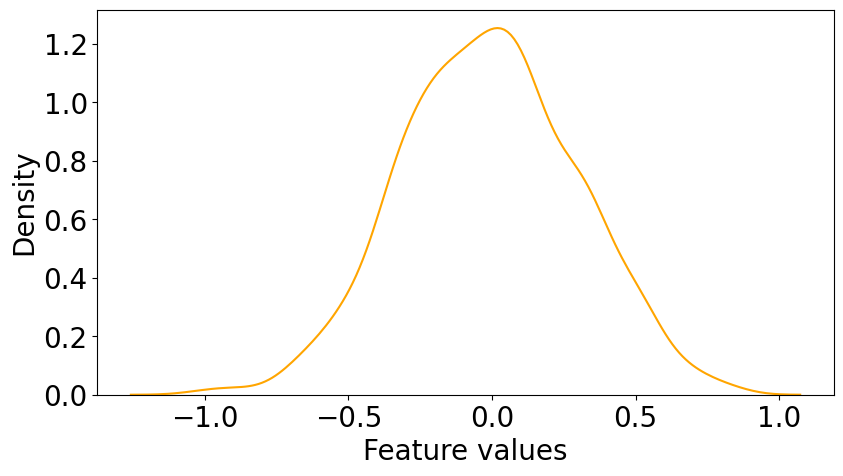

In [65]:
gene3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['gene'].numpy())
plot_node_feat(gene3_df)

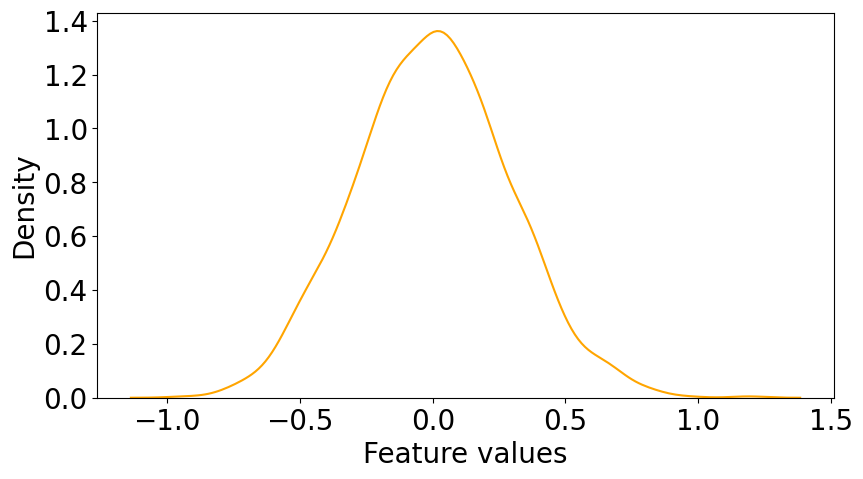

In [66]:
gene4_df = pd.DataFrame(nodefeature_dict[class4_nodeid]['gene'].numpy())
plot_node_feat(gene4_df)

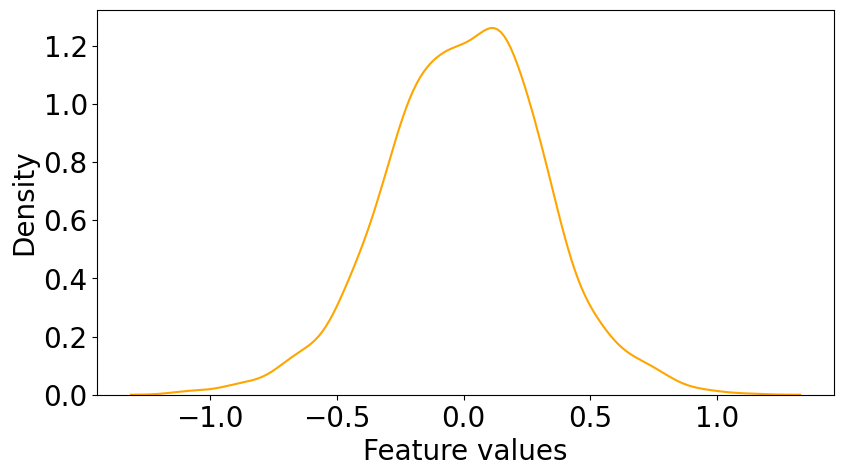

In [67]:
gene5_df = pd.DataFrame(nodefeature_dict[class5_nodeid]['gene'].numpy())
plot_node_feat(gene5_df)

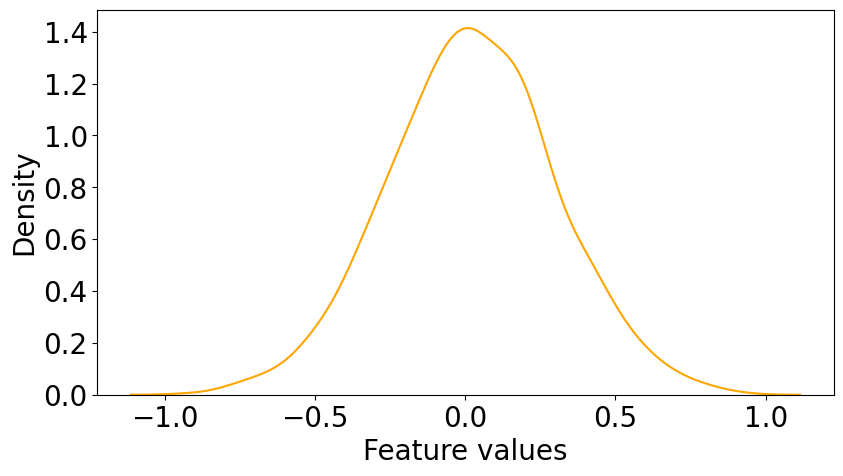

In [68]:
gene6_df = pd.DataFrame(nodefeature_dict[class6_nodeid]['gene'].numpy())
plot_node_feat(gene6_df)

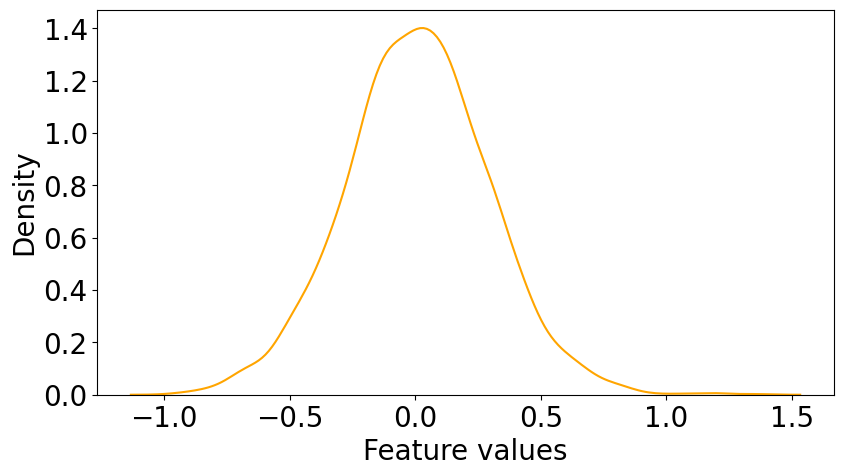

In [69]:
gene7_df = pd.DataFrame(nodefeature_dict[class7_nodeid]['gene'].numpy())
plot_node_feat(gene7_df)

In [70]:
#Chemical

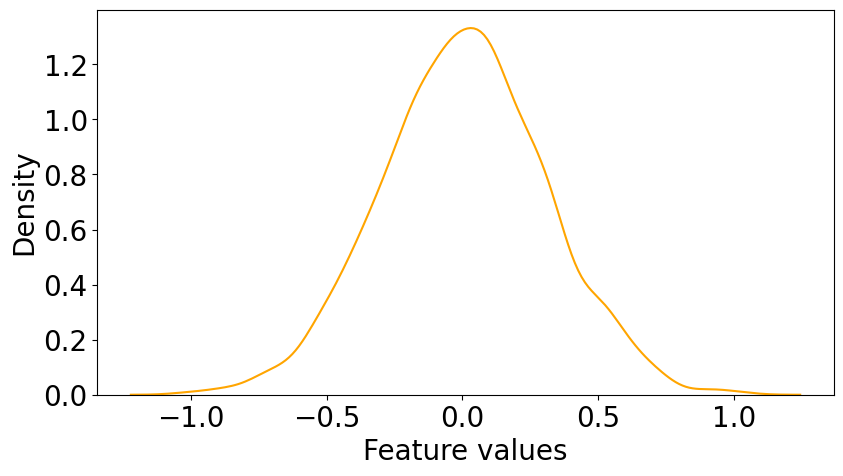

In [71]:
chemical0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['chemical'].numpy())
plot_node_feat(chemical0_df)

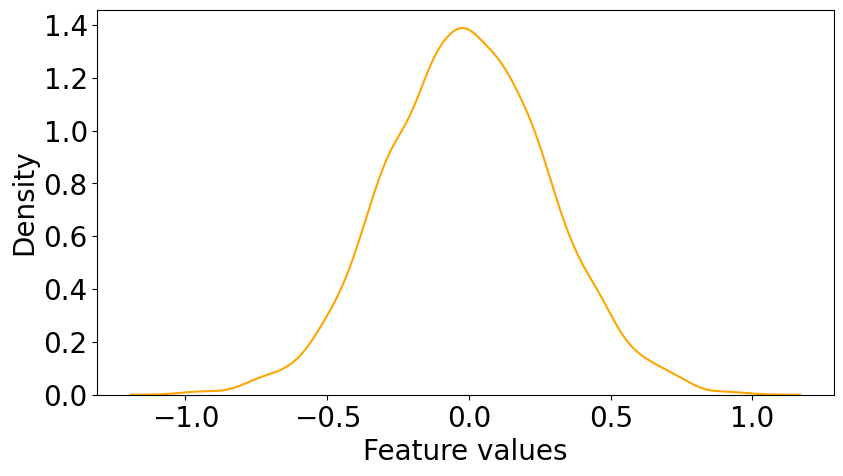

In [72]:
chemical1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['chemical'].numpy())
plot_node_feat(chemical1_df)

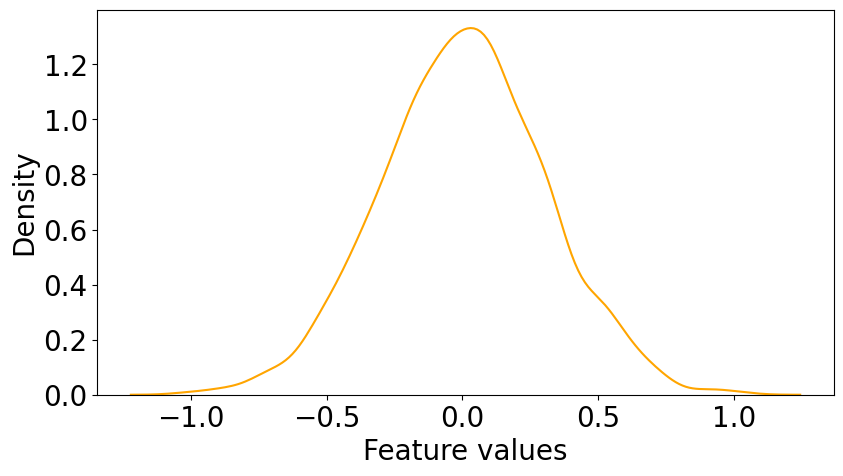

In [73]:
chemical2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['chemical'].numpy())
plot_node_feat(chemical2_df)

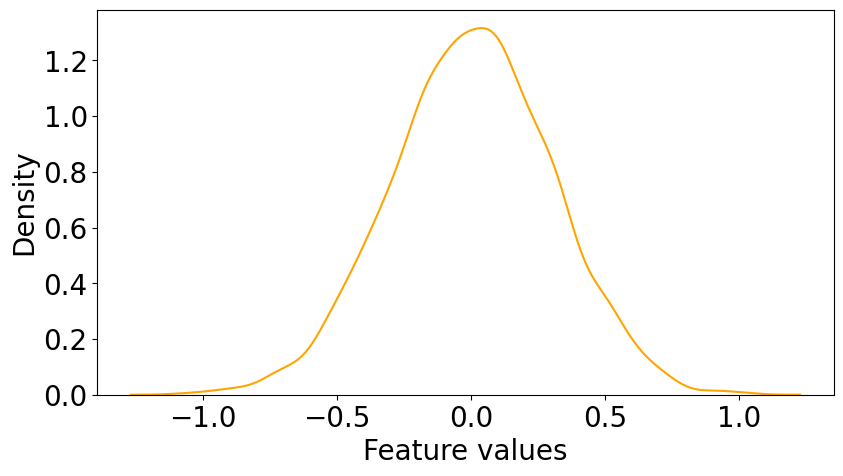

In [74]:
chemical3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['chemical'].numpy())
plot_node_feat(chemical3_df)

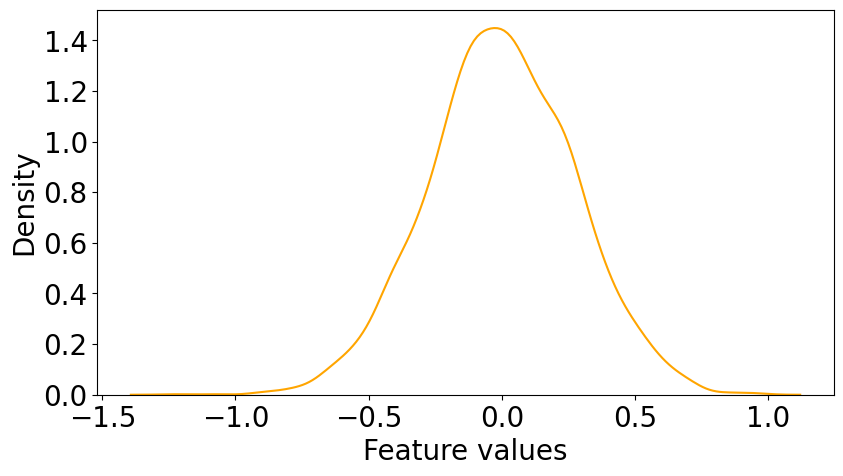

In [75]:
chemical4_df = pd.DataFrame(nodefeature_dict[class4_nodeid]['chemical'].numpy())
plot_node_feat(chemical4_df)

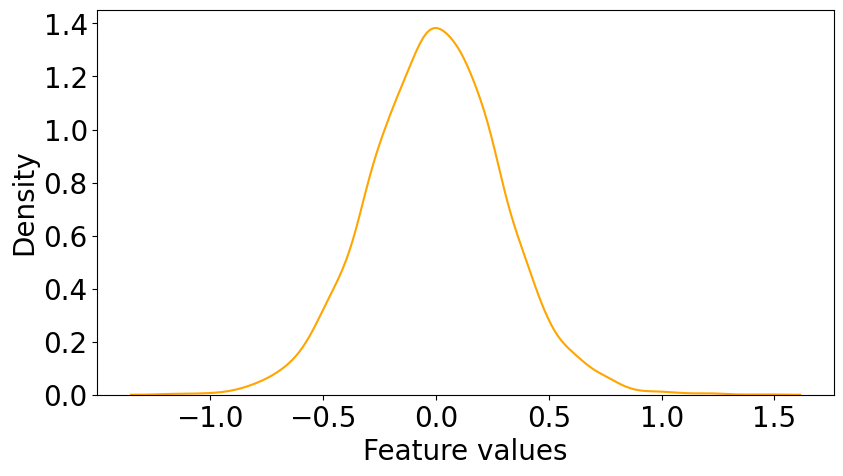

In [76]:
chemical5_df = pd.DataFrame(nodefeature_dict[class5_nodeid]['chemical'].numpy())
plot_node_feat(chemical5_df)

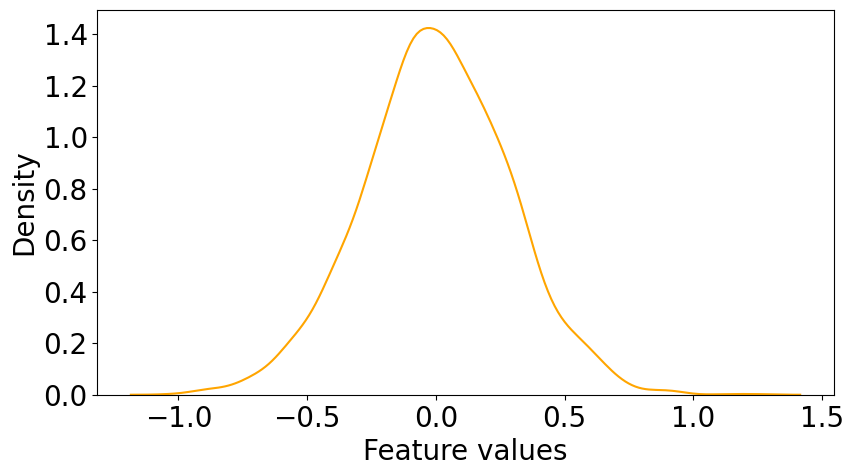

In [77]:
chemical6_df = pd.DataFrame(nodefeature_dict[class6_nodeid]['chemical'].numpy())
plot_node_feat(chemical6_df)

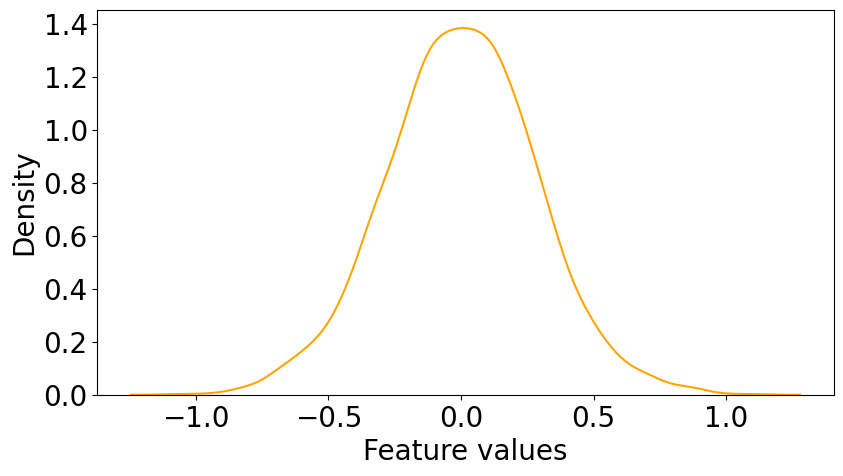

In [78]:
chemical7_df = pd.DataFrame(nodefeature_dict[class7_nodeid]['chemical'].numpy())
plot_node_feat(chemical7_df)

In [79]:
#Species

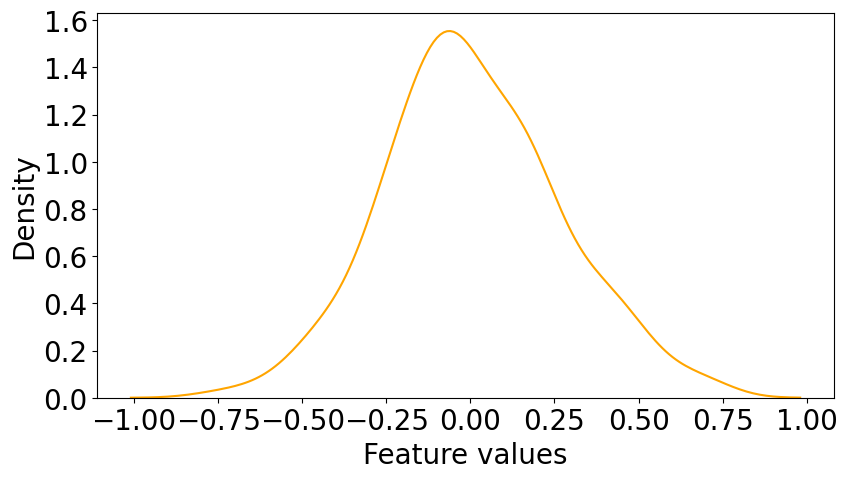

In [80]:
species0_df = pd.DataFrame(nodefeature_dict[class0_nodeid]['species'].numpy())
plot_node_feat(species0_df)

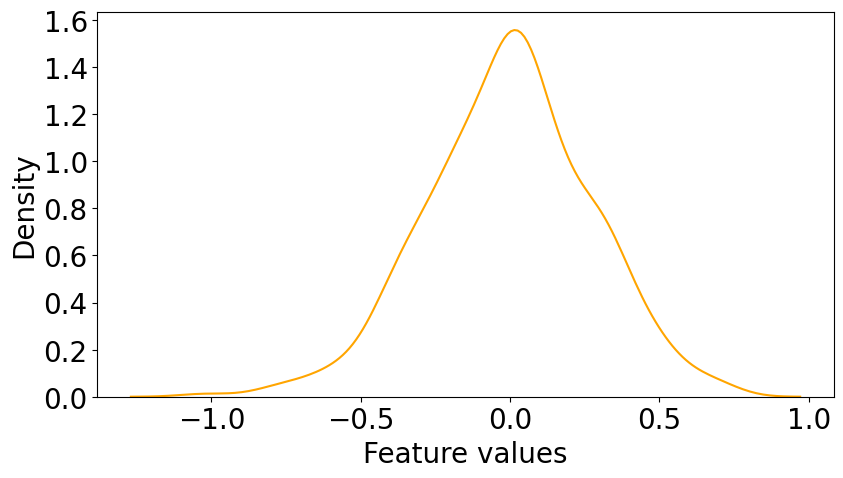

In [81]:
species1_df = pd.DataFrame(nodefeature_dict[class1_nodeid]['species'].numpy())
plot_node_feat(species1_df)

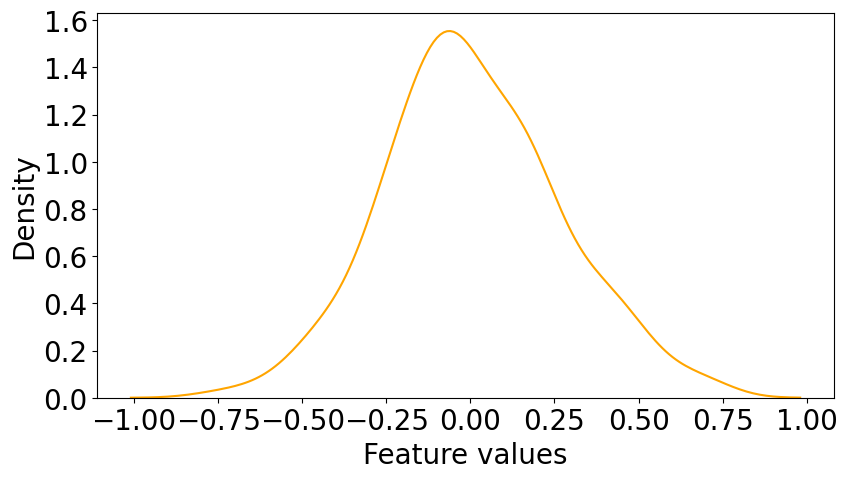

In [82]:
species2_df = pd.DataFrame(nodefeature_dict[class2_nodeid]['species'].numpy())
plot_node_feat(species2_df)

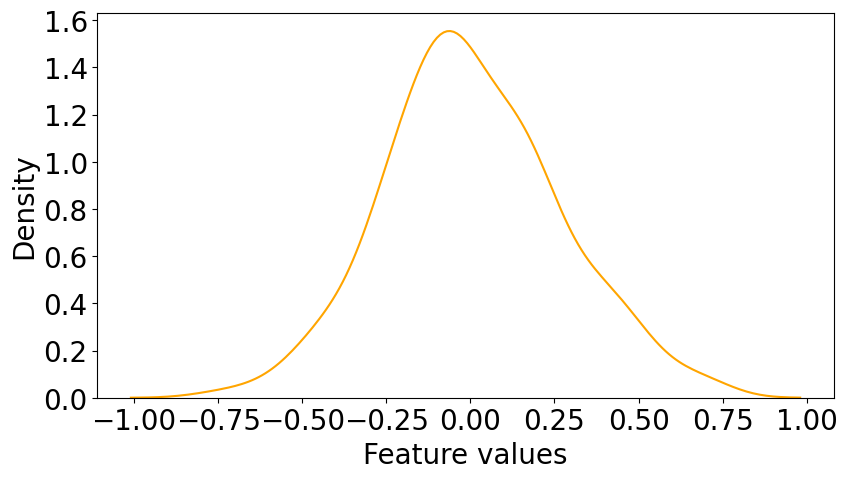

In [83]:
species3_df = pd.DataFrame(nodefeature_dict[class3_nodeid]['species'].numpy())
plot_node_feat(species3_df)

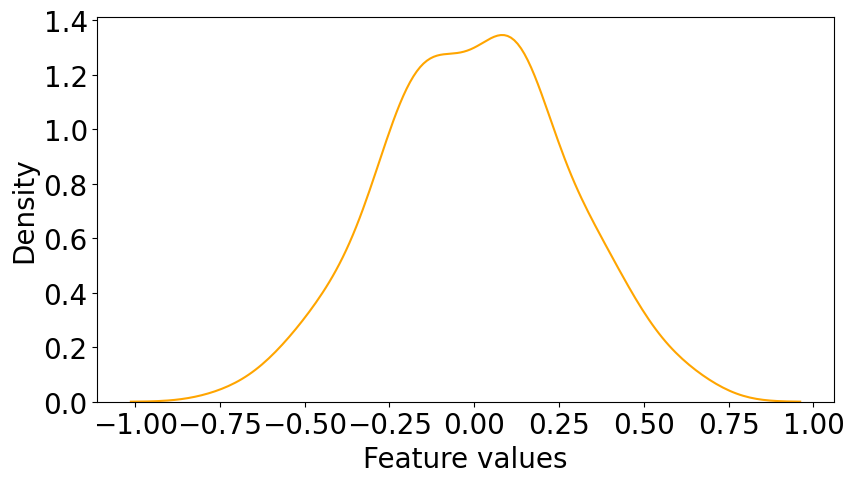

In [84]:
species4_df = pd.DataFrame(nodefeature_dict[class4_nodeid]['species'].numpy())
plot_node_feat(species4_df)

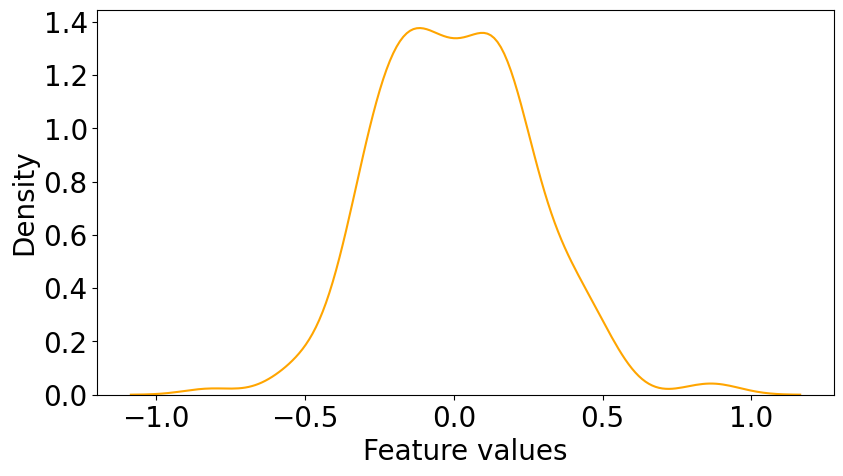

In [85]:
species5_df = pd.DataFrame(nodefeature_dict[class5_nodeid]['species'].numpy())
plot_node_feat(species5_df)

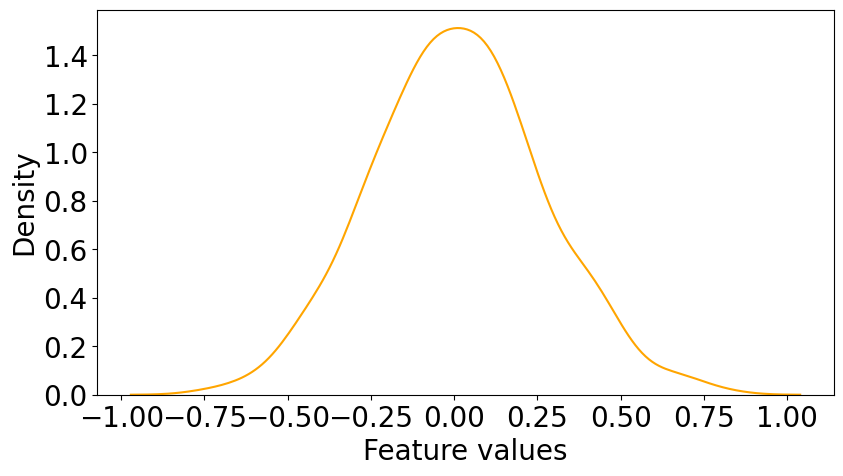

In [86]:
species6_df = pd.DataFrame(nodefeature_dict[class6_nodeid]['species'].numpy())
plot_node_feat(species6_df)

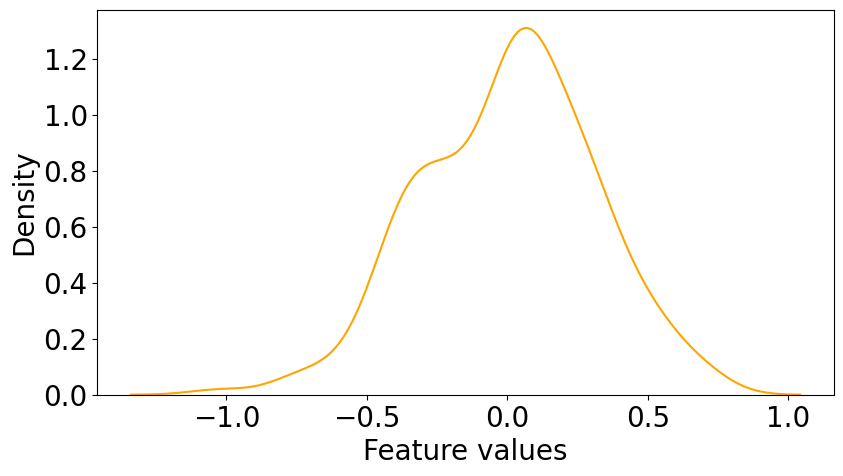

In [87]:
species7_df = pd.DataFrame(nodefeature_dict[class7_nodeid]['species'].numpy())
plot_node_feat(species7_df)